In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
import time
from sklearn import *
import re
from tqdm import*
import warnings
import catboost as ctb
import lightgbm as lgbm
warnings.filterwarnings('ignore')
tqdm.pandas()
from collections import*
plt.style.use('ggplot')

In [2]:

df = pd.read_csv('avito_data_clean.csv')

In [3]:
df.clean = df.street + ' '+ df.dom.astype('str')

In [4]:
df.district=df.district.fillna('Missed')

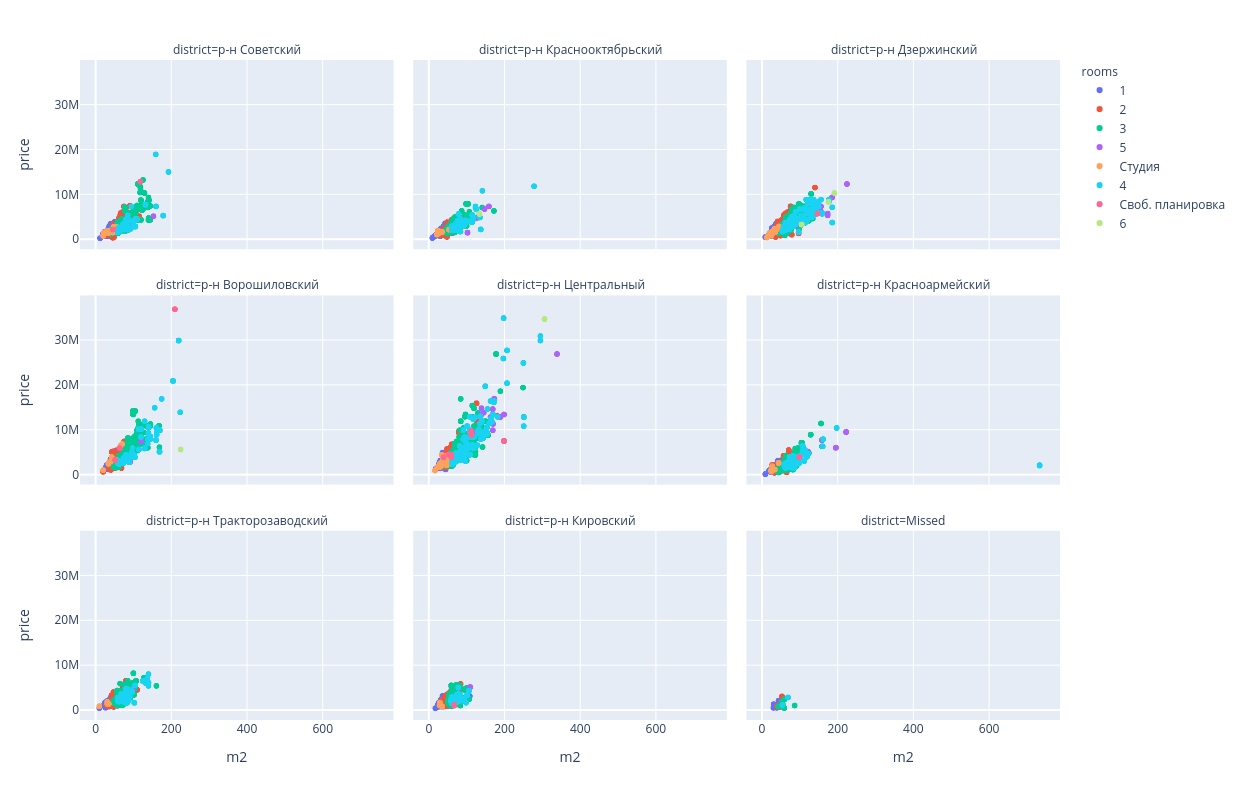

In [5]:
px.scatter(df,x='m2',y='price',color='rooms',facet_col='district',facet_col_wrap=3,height=800)

In [6]:
df.shape

(19252, 13)

In [7]:
df=df[df['m2']<np.percentile(df.m2,99.5)]

In [8]:
df=df[df['rubm2']<np.percentile(df['rubm2'],99.5)]

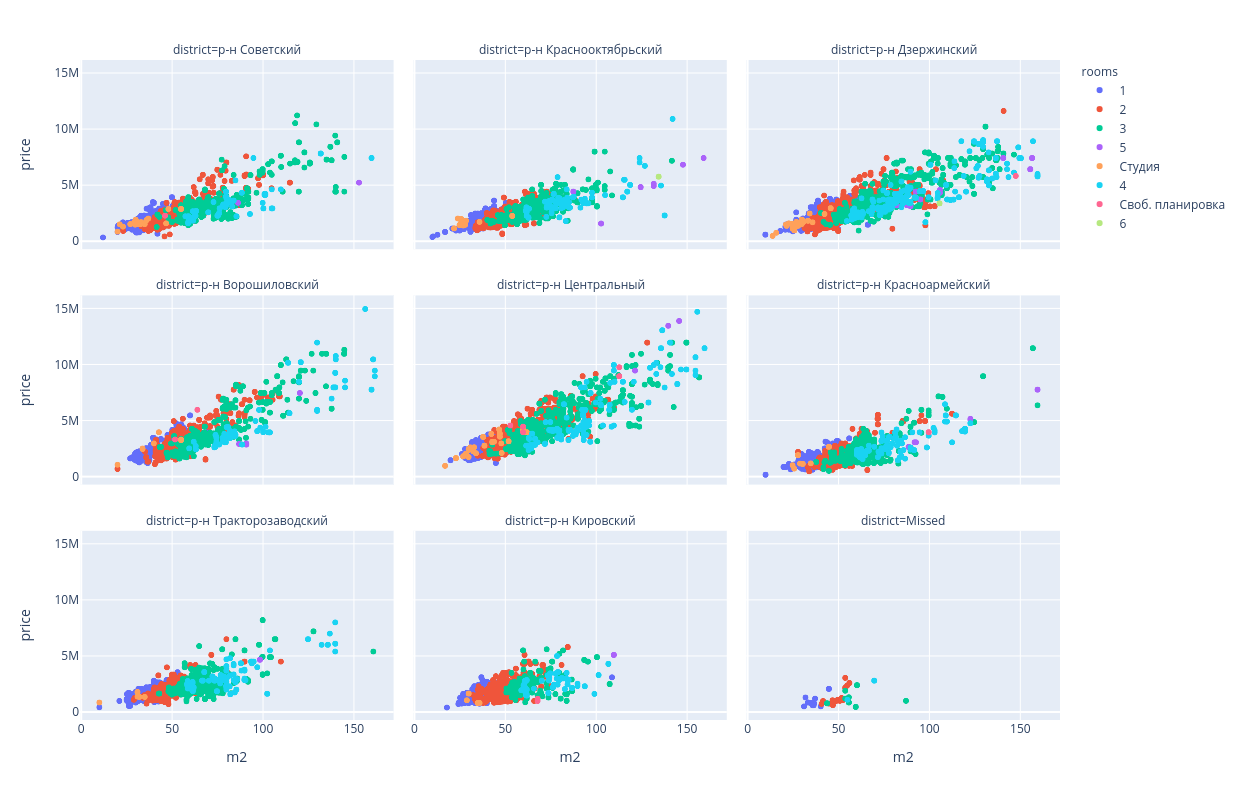

In [9]:
px.scatter(df,x='m2',y='price',color='rooms',facet_col='district',facet_col_wrap=3,height=800)

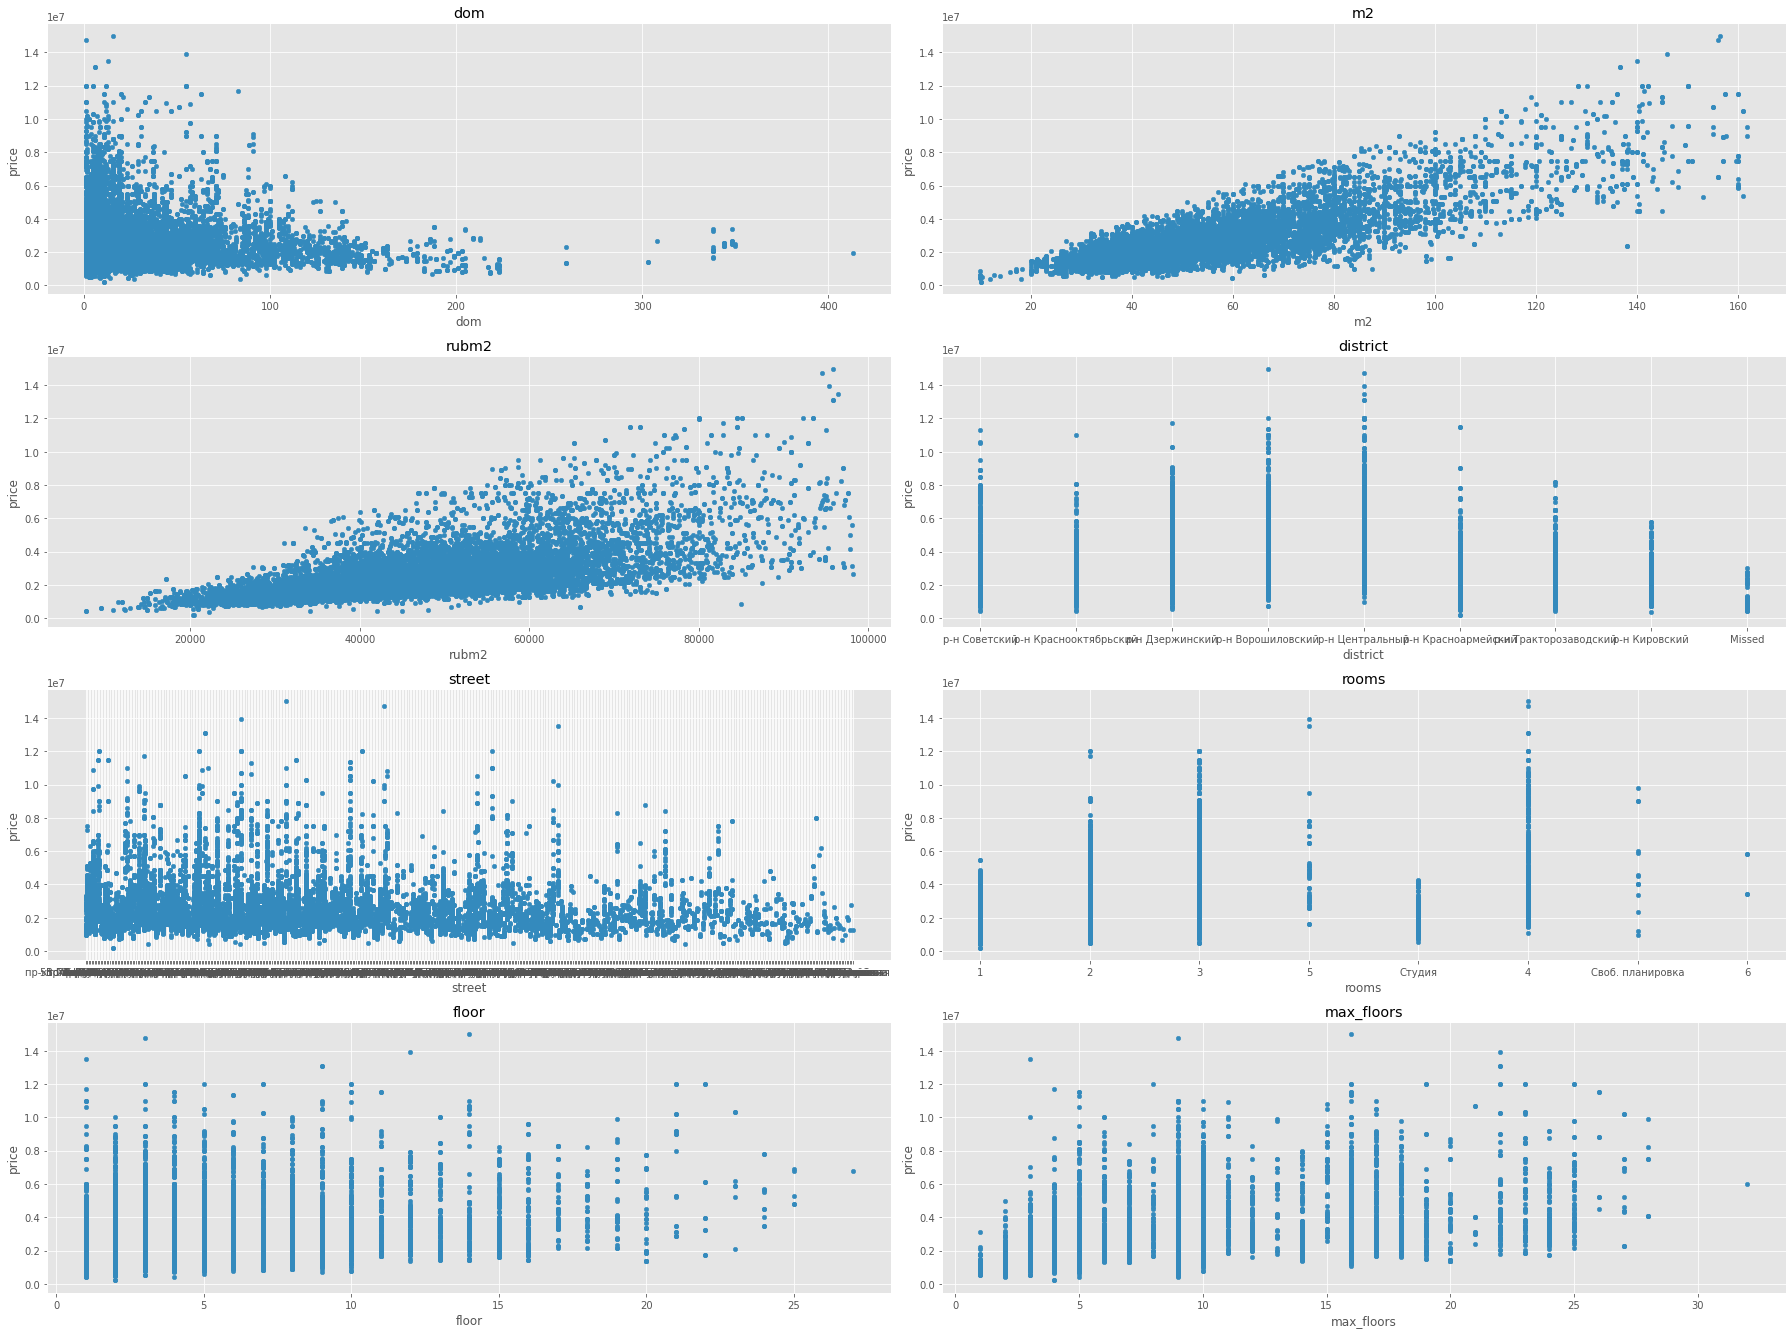

In [10]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['dom','m2','rubm2','district','street','rooms','floor','max_floors']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df.plot.scatter(x=column,y='price',ax=ax)
  plt.tight_layout()

Scatterplot pretty clearly intruduce to us some oblivious outliners that can hurt model pretty hard

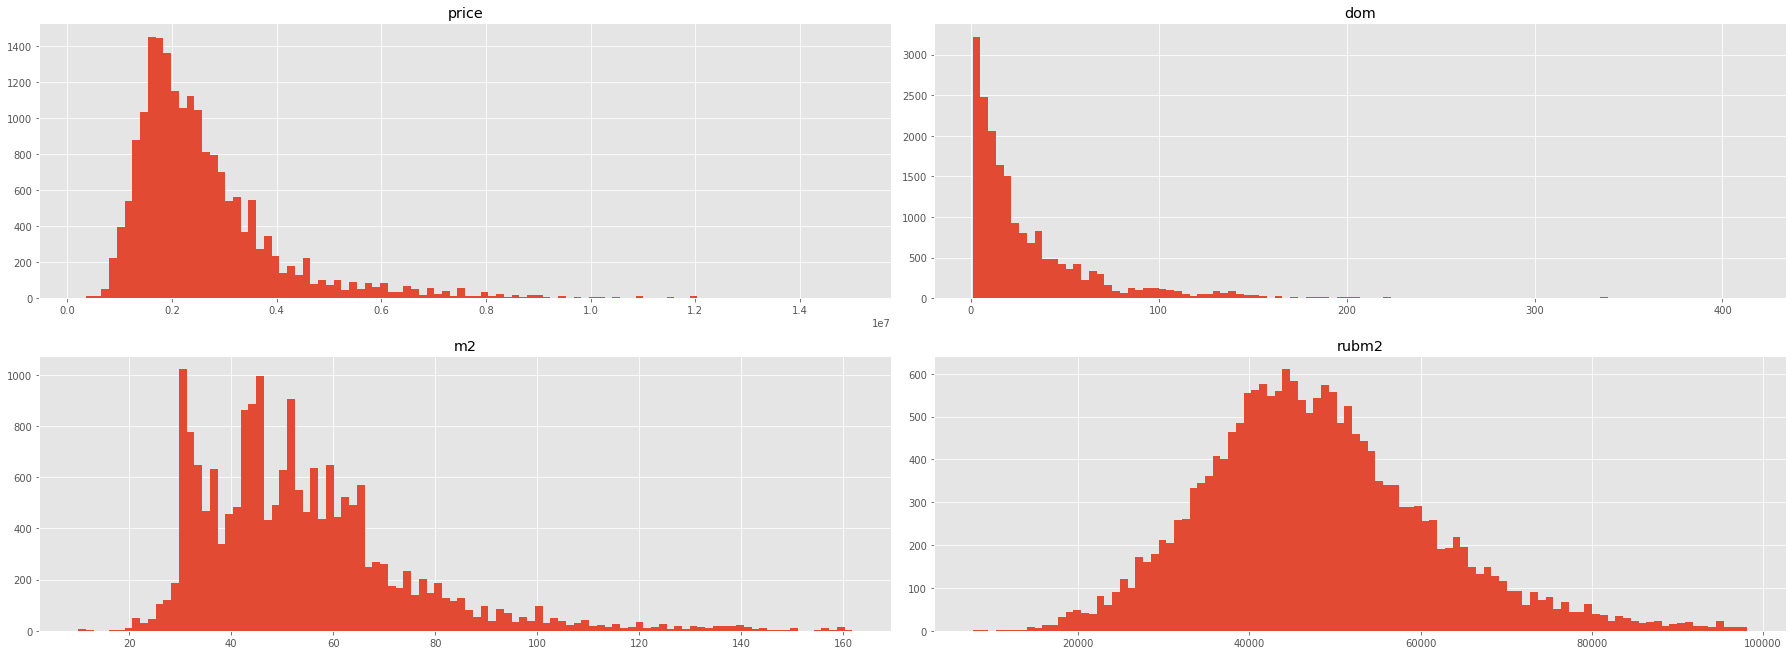

In [11]:
fig = plt.figure(figsize=(25,35*2.5))
for j,column in tqdm_notebook(enumerate(df[['price', 'dom', 'm2', 'rubm2']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].hist(bins=100,ax=ax)
  plt.tight_layout()

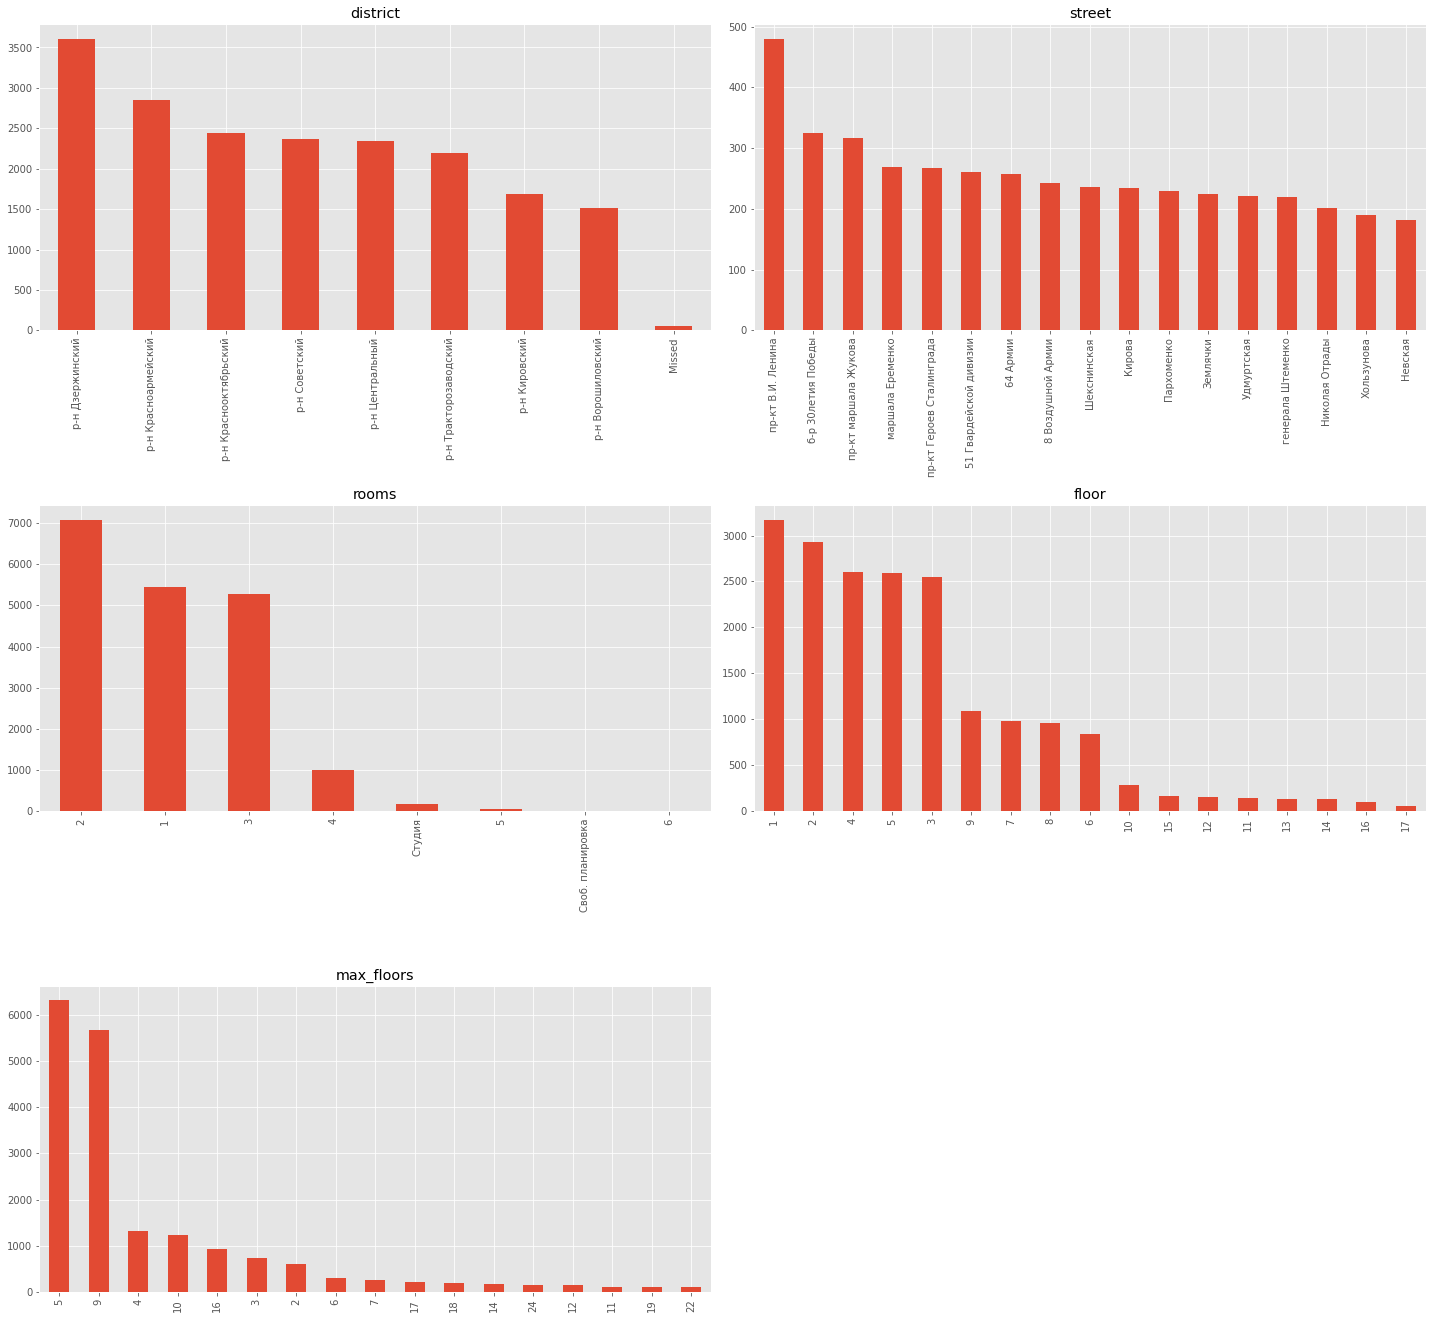

In [12]:
fig = plt.figure(figsize=(20,50*2.5))
for j,column in tqdm_notebook(enumerate(df[['district','street',
       'rooms', 'floor','max_floors']])):
  ax=fig.add_subplot(19,2,j+1)
  ax.set_title(column)
  df[column].value_counts()[:17].plot.bar(ax=ax)
  plt.tight_layout()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f237c08b0>,
      dtype=object)

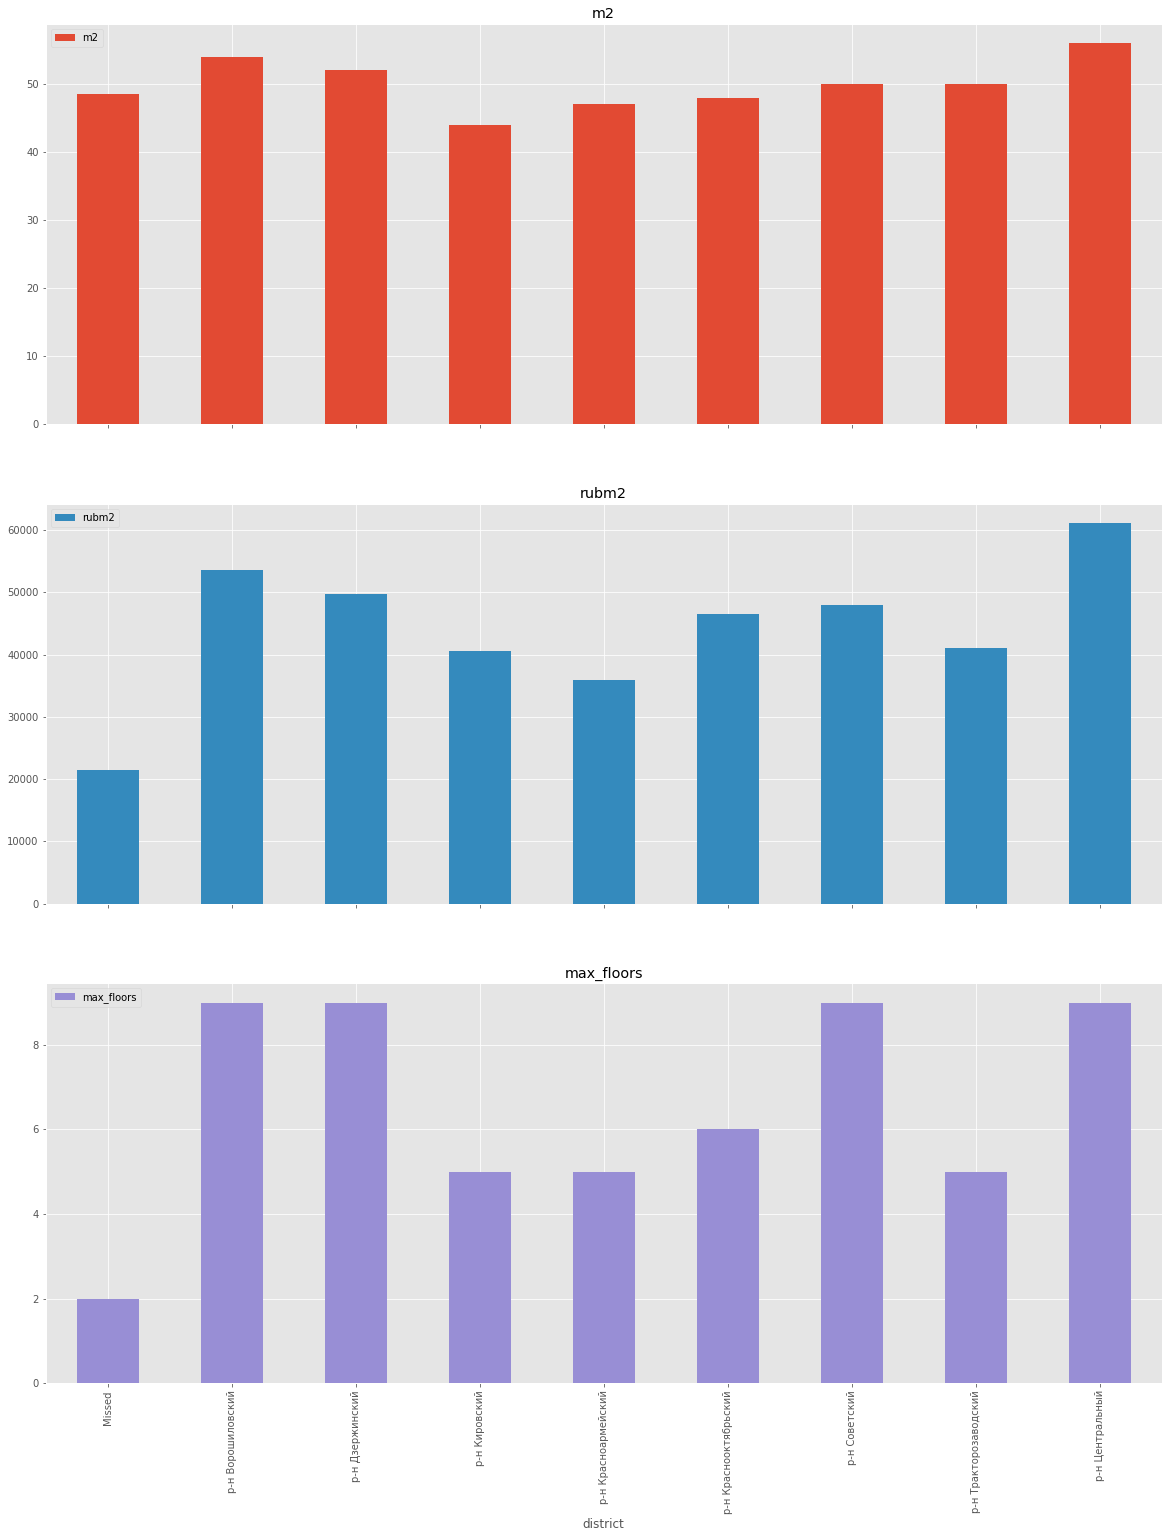

In [13]:
df.groupby(['district'])[['m2','rubm2','max_floors']].median().plot.bar(subplots=True,figsize=(20,25))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f2ba6f640>,
      dtype=object)

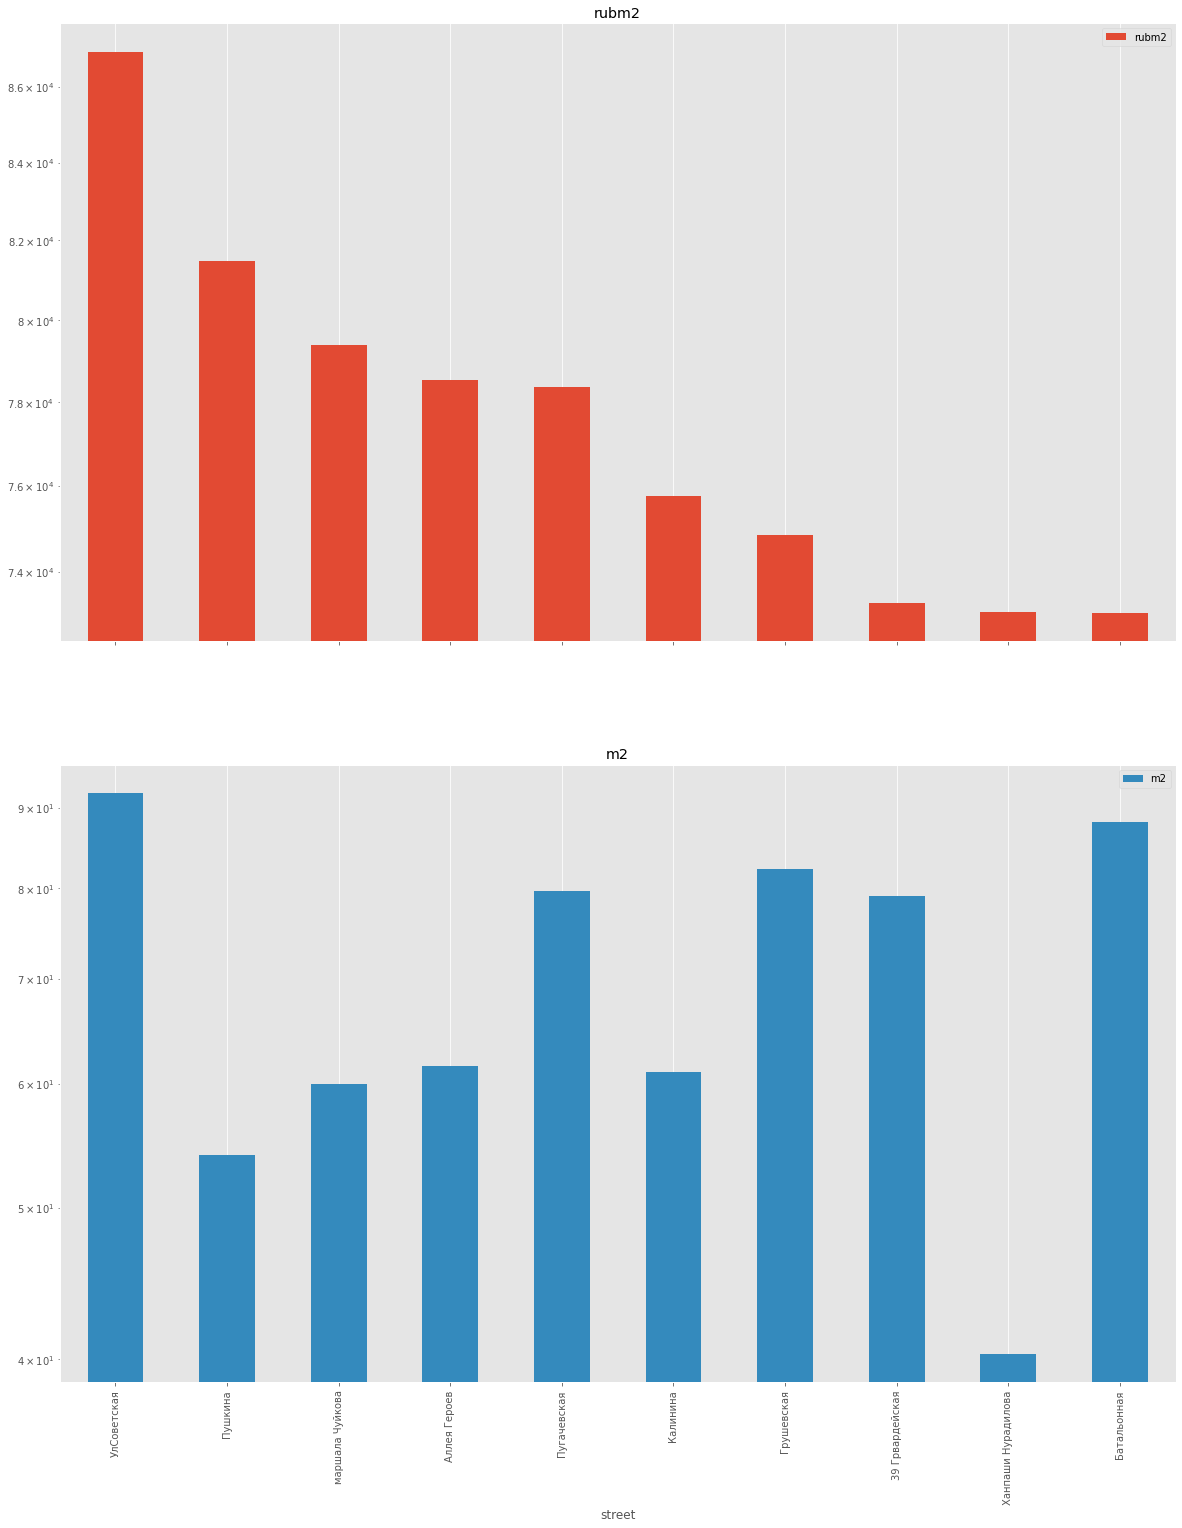

In [14]:
df.groupby('street')['rubm2','m2'].median().sort_values(by='rubm2',ascending=False)[:10].plot.bar(subplots=True,logy=True,figsize=(20,25))

In [15]:
df.head()

adress  \
0  Советский район, Горьковский, Волгоградская, 162   
1                                  Хользунова, 18/3   
2                                      Аэропорт, 16   
3                                      Лавочкина, 7   
4                          Волгоград, Богунская, 12   

                             info    price               district  \
0    1-к квартира, 32 м², 1/2 эт.   970000          р-н Советский   
1  1-к квартира, 40 м², 16/17 эт.  2000000  р-н Краснооктябрьский   
2  1-к квартира, 30.3 м², 2/5 эт.  1290000        р-н Дзержинский   
3   1-к квартира, 41 м², 8/22 эт.  3050000      р-н Ворошиловский   
4  1-к квартира, 32.4 м², 3/9 эт.  1700000  р-н Краснооктябрьский   

           date         street  dom              clean rooms    m2  floor  \
0  4 июня 16:38  Волгоградская  162  Волгоградская 162     1  32.0      1   
1  4 июня 14:35     Хользунова   18      Хользунова 18     1  40.0     16   
2  3 июня 16:12       Аэропорт   16        Аэропорт 16     1  30.3      2   
3  4 июня 17:59      Лавочкина    7        Лавочкина 7     1  41.0      8   
4  4 июня 17:42      Богунская   12       Богунская 12     1  32.4      3   

   max_floors         rubm2  
0           2  30312.500000  
1          17  50000.000000  
2           5  42574.257426  
3          22  74390.243902  
4           9  52469.135802

In [16]:
df['m2_range']=pd.cut(df.m2,bins=[0,30,57.8,88,116,df.m2.max()])

In [17]:
df['rub_by_district']=df.groupby(['district','rooms','max_floors'])['rubm2'].transform('mean')

In [18]:
gb_distr_rubm2=df.groupby(['district','rooms','max_floors'])['rubm2'].mean().rename('rub_by_district').reset_index()

In [19]:
gb_distr_count=df.groupby(['district','rooms','max_floors']).clean.count().rename('count_by_district').reset_index()

In [20]:
gb_street_count=df.groupby(['street','rooms','max_floors']).clean.count().rename('count_by_street').reset_index()

In [21]:
df['count_by_district']=df.groupby(['district','rooms','max_floors']).clean.transform('count')

In [22]:
df['count_by_street']=df.groupby(['street','rooms','max_floors']).clean.transform('count')

In [23]:
df.date=df.date.str.split(expand=True)[[0,1]].astype('str').apply(' '.join,axis=1)

In [24]:
df.date=df.date.replace('nan nan','4 июня')
df.date=df.date.str.replace(' июня',"/06/2020")
df.date= df.date.str.replace(' мая','/05/2020')
df.date= df.date.str.replace(' апреля','/04/2020')
df.date=pd.to_datetime(df.date)

In [25]:
df.groupby('district').mean()

price        dom         m2     floor  \
district                                                              
Missed                 1.258926e+06   7.365385  48.451923  2.115385   
р-н Ворошиловский      3.357466e+06  21.111257  59.244898  5.040158   
р-н Дзержинский        2.912198e+06  36.214800  57.210061  4.993902   
р-н Кировский          1.942112e+06  57.600711  47.434301  3.786730   
р-н Красноармейский    1.855544e+06  31.426017  50.107468  3.902875   
р-н Краснооктябрьский  2.419126e+06  37.044690  51.776138  4.444444   
р-н Советский          2.552166e+06  20.649768  52.874863  4.647233   
р-н Тракторозаводский  2.109681e+06  22.989977  51.119271  4.188155   
р-н Центральный        3.857612e+06  19.280889  61.373920  5.714408   

                       max_floors         rubm2  rub_by_district  \
district                                                           
Missed                   2.826923  25536.063296     25536.063296   
р-н Ворошиловский        9.111916  55750.653591     55750.653591   
р-н Дзержинский          8.751386  50844.628607     50844.628607   
р-н Кировский            6.459716  41658.818104     41658.818104   
р-н Красноармейский      6.611851  36774.674078     36774.674078   
р-н Краснооктябрьский    7.458385  47108.457032     47108.457032   
р-н Советский            7.870300  48514.647941     48514.647941   
р-н Тракторозаводский    7.028246  41710.082507     41710.082507   
р-н Центральный          9.953826  62538.122381     62538.122381   

                       count_by_district  count_by_street  
district                                                   
Missed                          7.884615         3.192308  
р-н Ворошиловский             104.602370        11.248848  
р-н Дзержинский               229.291020        19.684590  
р-н Кировский                 124.071090        21.342417  
р-н Красноармейский           273.402525        20.874474  
р-н Краснооктябрьский         207.921689        20.176302  
р-н Советский                 142.722856        12.626531  
р-н Тракторозаводский         166.211845        19.054670  
р-н Центральный               109.373664        16.404446

In [26]:
data = df.drop(['price','rubm2','clean','date','info','adress'],axis=1)
targ = df['price']

In [27]:
d_=defaultdict(preprocessing.LabelEncoder)

In [28]:
data.loc[:,data.select_dtypes(include=['category','O']).columns] = data.progress_apply(lambda x: d_[x.name].fit_transform(x) if x.dtype not in [float,int] else x)

100%|██████████| 11/11 [00:00<00:00, 179.03it/s]


In [29]:
data_manifold = data.copy()

In [30]:
data_manifold

district  street  dom  rooms     m2  floor  max_floors  m2_range  \
0             6      94  162      0   32.0      1           2         1   
1             5     438   18      0   40.0     16          17         1   
2             2      51   16      0   30.3      2           5         1   
3             1     247    7      0   41.0      8          22         1   
4             5      72   12      0   32.4      3           9         1   
...         ...     ...  ...    ...    ...    ...         ...       ...   
19244         8     272   24      3  107.5      4           5         3   
19245         7     228    9      3   61.5      4           5         2   
19246         5     438   36      3  117.4      3           9         4   
19248         2      21   30      7   21.7      7          10         0   
19250         1     185    2      3  114.0     21          27         3   

       rub_by_district  count_by_district  count_by_street  
0         38064.537811                 21                3  
1         49220.430376                 14               12  
2         49553.039306                251                3  
3         67969.975551                 12               12  
4         52763.382062                219                2  
...                ...                ...              ...  
19244     58041.334647                 47                3  
19245     36679.514754                 41                9  
19246     43406.362595                 43                2  
19248     62727.534869                  6                6  
19250     89473.684211                  2                2  

[19059 rows x 11 columns]

In [31]:
x,xv,y,yv = model_selection.train_test_split(data,targ,test_size= 0.2)

In [32]:
x.head()

district  street  dom  rooms    m2  floor  max_floors  m2_range  \
949           6     458    4      0  33.0      3           4         1   
2712          6     339    2      0  30.9      5           5         1   
13975         7     256    9      1  51.4     10          10         1   
6037          4      76    3      1  45.6      4           5         1   
3441          2     285    6      1  50.9      2           9         1   

       rub_by_district  count_by_district  count_by_street  
949       47391.408340                 73                1  
2712      47614.341976                209                2  
13975     50744.952892                 62                7  
6037      34364.935222                404               39  
3441      52852.501400                446               10

In [33]:
cat_feats=['district','street','rooms','m2_range']

In [34]:
lgb_set = lgbm.Dataset(data,targ,categorical_feature=cat_feats)

In [35]:
params ={'n_estimators':5000,
     "objective" : "regression",
        "metric" : "rmse",
     'verbose':200,
        'silent':False}

In [36]:
lgb_cv = lgbm.cv(params=params,train_set=lgb_set,nfold=3,stratified=False)

In [37]:
pd.DataFrame(lgb_cv).sort_values(by='rmse-mean')

rmse-mean     rmse-stdv
4879  3.227682e+05   5931.877846
4867  3.227685e+05   5934.207247
4873  3.227690e+05   5934.195425
4871  3.227692e+05   5939.357697
4872  3.227700e+05   5938.239544
...            ...           ...
4     9.597196e+05   6214.151228
3     1.032413e+06   7154.058205
2     1.114151e+06   8268.114164
1     1.206973e+06   9471.653811
0     1.312439e+06  10913.124507

[5000 rows x 2 columns]

In [38]:
lgb_cv['rmse-mean'][-1]

322809.9082238917

In [39]:
lgb = lgbm.LGBMRegressor(n_estimators=5000,silent=False,categorical_features=cat_feats,random_state=1)
lgb.fit(data,targ,verbose=200)

LGBMRegressor(categorical_features=['district', 'street', 'rooms', 'm2_range'],
              n_estimators=5000, random_state=1, silent=False)

In [40]:
def score_comp(booster,dic,values=None,predict=True):
    for i in [metrics.r2_score,metrics.mean_absolute_error,metrics.max_error]:
        if predict==True:
            dic[booster.__class__.__name__].append(i(yv,booster.predict(xv)))
        else:
            dic[booster].append(i(yv,values))

In [41]:
score = defaultdict(list)

In [42]:
score_comp(lgb,score)

In [43]:
knn=neighbors.KNeighborsRegressor(n_neighbors=1)
knn.fit(x,y)
score_comp(knn,score)

In [44]:
from bayes_opt import BayesianOptimization

In [47]:
X_train=data # analysing data
y_train=targ #analysing target
categorical_features=cat_feats #categorical features in set
#num of parametrs must match in lgb_eval & optimisition
def lgb_eval(num_leaves,max_depth,lambda_l2,lambda_l1,
             min_child_samples,
             mcw,
             #min_data_in_leaf,
             #n_estimators,
             lr):
    #parametrs for tuning
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        #'device':'gpu'
        'min_child_weight':mcw,
        'is_unbalance': False,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "lambda_l2" : lambda_l2,
        "lambda_l1" : lambda_l1,
        "min_child_samples" : int(min_child_samples),
       # 'min_data_in_leaf': int(min_data_in_leaf),
        "learning_rate" : lr,
        #'n_estimators':int(n_estimators)
    }
    lgtrain = lgbm.Dataset(X_train, y_train,categorical_feature=categorical_features)
    #testing feature, almost always some kind of cv
    cv_result = lgbm.cv(params,
                       lgtrain,
                       5000,
                       early_stopping_rounds=500,
                       stratified=False,
                       nfold=3)
    return -cv_result['rmse-mean'][-1]

In [48]:
lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (1, 4000),
                                                'max_depth': (-1, 63),
                                                'lambda_l2': (0.0, 10),
                                                'lambda_l1': (0.0, 10),
                                                'min_child_samples': (5, 100),
                                        'mcw':(0.0001,0.1),
                                                'lr':(0.0001,0.3)
                                                })

lgbBO.maximize(n_iter=25, init_points=10)

|   iter    |  target   | lambda_l1 | lambda_l2 |    lr     | max_depth |    mcw    | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
|  1        | -3.479e+0 |  3.643    |  6.354    |  0.2981   |  16.19    |  0.05825  |  94.57    |  3.97e+03 |
|  2        | -3.362e+0 |  5.338    |  4.294    |  0.1192   |  46.95    |  0.06734  |  55.83    |  2.202e+0 |
|  3        | -3.451e+0 |  0.02542  |  8.259    |  0.03404  |  40.4     |  0.00744  |  88.2     |  1.073e+0 |
|  4        | -3.372e+0 |  0.4392   |  9.426    |  0.196    |  24.72    |  0.02561  |  55.09    |  2.157e+0 |
|  5        | -3.408e+0 |  2.983    |  1.501    |  0.2533   |  53.23    |  0.01509  |  18.54    |  399.7    |
|  6        | -3.409e+0 |  6.359    |  1.135    |  0.2303   |  4.37     |  0.06305  |  65.44    |  2.202e+0 |
|  7        | -3.346e+0 |  2.113    |  2.343    |  0.06687  |  19.57    |  0.07347  |  48.86    |  3.089e+0 |
|  8      

In [49]:
lgbBO.max

{'target': -323607.23629245843,
 'params': {'lambda_l1': 6.847187469233007,
  'lambda_l2': 9.213786616790411,
  'lr': 0.06983070857590447,
  'max_depth': 21.904575871720283,
  'mcw': 0.06407670369663403,
  'min_child_samples': 17.957579960479684,
  'num_leaves': 2654.1807063743}}

In [50]:
lgbBO.max['params']

{'lambda_l1': 6.847187469233007,
 'lambda_l2': 9.213786616790411,
 'lr': 0.06983070857590447,
 'max_depth': 21.904575871720283,
 'mcw': 0.06407670369663403,
 'min_child_samples': 17.957579960479684,
 'num_leaves': 2654.1807063743}

In [51]:
cat = ctb.CatBoostRegressor(iterations = 5000, verbose=200,
                                early_stopping_rounds=500,
                               cat_features=[0,1,2,3,5,6,7]
                           )

In [52]:
cat.fit(x,y,eval_set=(xv,yv))

Learning rate set to 0.028291
0:	learn: 1390456.5766506	test: 1446533.4552411	best: 1446533.4552411 (0)	total: 59.6ms	remaining: 4m 58s
200:	learn: 482717.1252790	test: 484632.7419728	best: 484632.7419728 (200)	total: 1.56s	remaining: 37.2s
400:	learn: 444889.2332426	test: 455772.9092920	best: 455772.9092920 (400)	total: 2.92s	remaining: 33.5s
600:	learn: 417469.1282728	test: 439162.8164819	best: 439162.8164819 (600)	total: 4.29s	remaining: 31.4s
800:	learn: 395005.9501205	test: 424385.5304779	best: 424385.5304779 (800)	total: 5.83s	remaining: 30.6s
1000:	learn: 376386.0842576	test: 413818.8276040	best: 413818.8276040 (1000)	total: 7.23s	remaining: 28.9s
1200:	learn: 361522.5841988	test: 406290.7771294	best: 406290.7771294 (1200)	total: 8.65s	remaining: 27.4s
1400:	learn: 350075.0875693	test: 400704.7076469	best: 400704.7076469 (1400)	total: 10s	remaining: 25.8s
1600:	learn: 340029.9013145	test: 395414.8638327	best: 395414.8638327 (1600)	total: 11.4s	remaining: 24.3s
1800:	learn: 33063

In [53]:
score_comp(cat,score)

In [54]:
pd.DataFrame(score).style

In [55]:
def predict_price(data=None,log1p=False,alg=lgb):
    if data!= None:
        d=data
        d['m2_range']=df['m2_range'].unique()[[(d['m2'] in i ) for i in df['m2_range'].unique()]][0]
    else:
        d = collections.defaultdict(list)
        for info in cat.feature_names_[:-4]:
            print( f'Input {info}, example :{df[info].unique()[:3]}')
            d[info] = input()
        d['max_floors']=int(d['max_floors'])
        d['m2']=int(d['m2'])
        d['m2_range']=df['m2_range'].unique()[[(d['m2'] in i ) for i in df['m2_range'].unique()]][0]
    #d['clean'] = d['street'] + ','+str(d['dom'])
    d['street'] = df[df.street.str.contains(d['street'])].street.mode()[0]
    home_df = pd.DataFrame(d,index=[0])
    for i in [gb_distr_rubm2,gb_distr_count,gb_street_count]:
        home_df = home_df.merge(i, how='left',on=i.columns[:-1].to_list())
    try:
        cat_df=home_df.apply(lambda x: d_[x.name].transform(x) if x.name in list(d_.keys()) else x)
    except:
        try:
            street = df[df.street.str.contains(d['street'])].street.mode()[0]
            idx_nearest=df.query('street==@street')['dom'].apply(lambda x: abs(x-d['dom'])).sort_values()[:1].index[0]
            home_df.loc[0,'dom'] = df['dom'].loc[idx_nearest]
            home_df['clean'] = home_df['street'] + ','+home_df['dom'].astype(str)
            print('some info from : ',home_df['clean'][0])
            cat_df=home_df.apply(lambda x: d_[x.name].transform(x) if x.name in list(d_.keys()) else x)
        except:
            gb__=df.groupby(['district','rooms','max_floors'])['clean'].apply(pd.Series.mode).reset_index().drop('level_3',axis=1)
            home_df=home_df.merge(gb__,how='left',on=gb__.columns.to_list()[:-1])
            home_df[['street','dom']] = home_df.clean.str.split(',',expand=True)
            print('some info from : ',home_df['clean'][0])
            cat_df=home_df.apply(lambda x: d_[x.name].transform(x) if x.name in list(d_.keys()) else x)
    #cat_df = cat_df[cat.feature_names_]
    price=alg.predict(cat_df)
    return(price)

In [56]:
d_tr= {}

In [57]:
d_tr['district'] = 'р-н Краснооктябрьский'
d_tr['street'] = 'Триумфальная'
d_tr['dom'] = 24
d_tr['rooms'] = '3'
d_tr['m2'] = 68
d_tr['floor'] = 7
d_tr['max_floors'] = 9

In [58]:
predict_price(d_tr)

array([3365180.44137932])

In [59]:
d_pod = {}
d_pod['district'] = 'р-н Краснооктябрьский'
d_pod['street'] = 'Поддубного'
d_pod['dom'] = 29
d_pod['rooms'] = '2'
d_pod['m2'] = 42
d_pod['floor'] = 5
d_pod['max_floors'] = 5

In [60]:
predict_price(d_pod)


array([1881384.40107647])

In [61]:
d_ere= {}
d_ere['district'] = 'р-н Краснооктябрьский'
d_ere['street'] = 'Еременко'
d_ere['dom'] = 102
d_ere['rooms'] = '2'
d_ere['m2'] = 50
d_ere['floor'] = 4
d_ere['max_floors'] = 5

In [62]:
predict_price(d_ere)


array([2104279.94190886])

In [63]:
blend_boosters = cat.predict(xv)*.5+lgb.predict(xv)*.5

score_comp('blend_boosters',score,values=blend_boosters,predict=False)

blend = cat.predict(xv)*.35+lgb.predict(xv)*.35 + knn.predict(xv)*.3

score_comp('blend',score,values=blend,predict=False)

pd.DataFrame(score).style

In [64]:
import shap

In [65]:
expl=shap.TreeExplainer(lgb)

In [66]:
shap_val=expl.shap_values(data,targ)

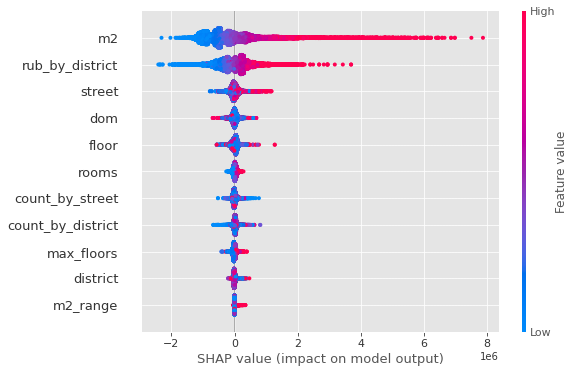

In [67]:
shap.summary_plot(shap_val,data)

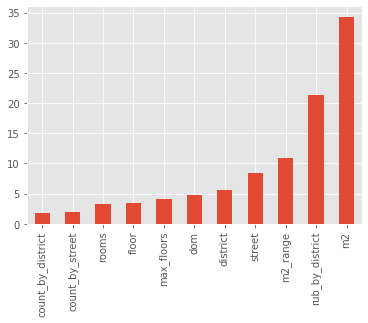

In [68]:
pd.Series(cat.feature_importances_,cat.feature_names_).sort_values().plot.bar()

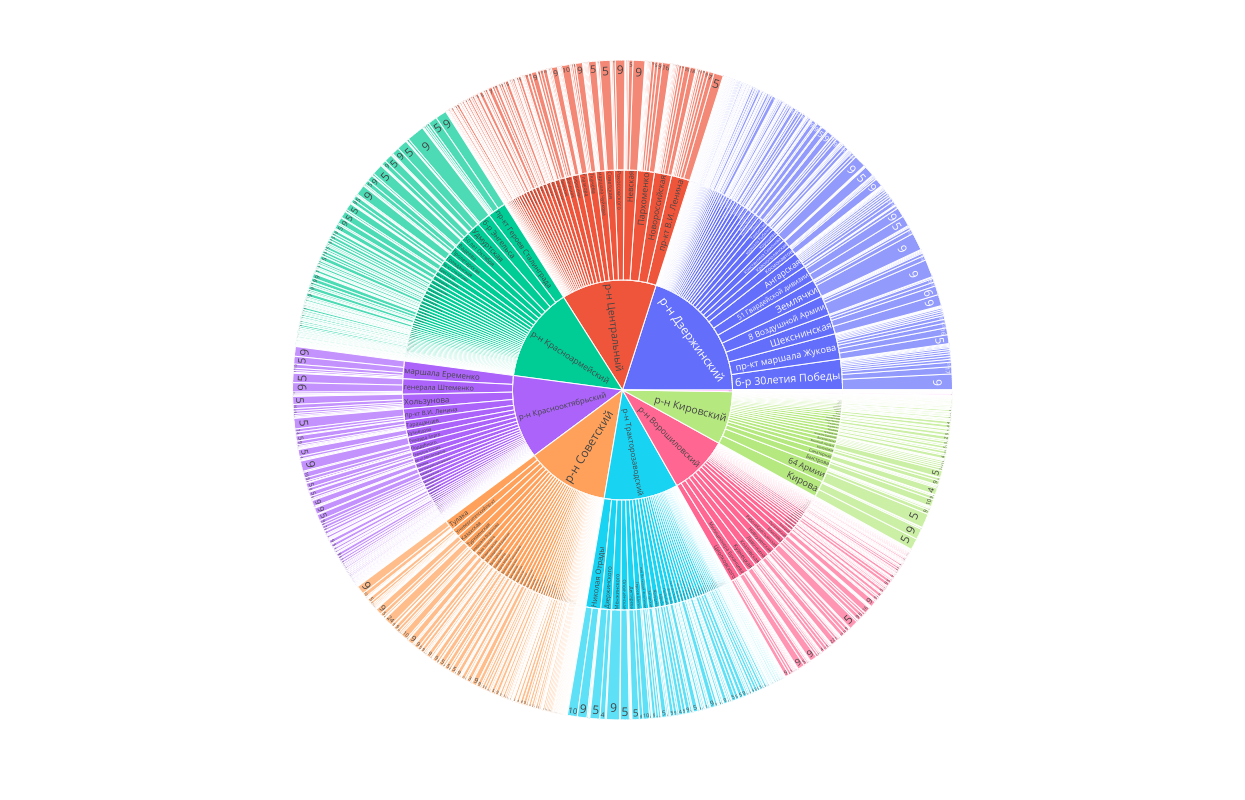

In [69]:
px.sunburst(
    df,
    path=['district','street','max_floors'],
    values='m2',
    height=800
)